In [1]:
# Cell 1 - Imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

RANDOM_STATE = 42
sns.set_style("whitegrid")


In [2]:
# Cell 2 - Load dataset (make sure heart_failure.csv is in same folder)
df = pd.read_csv("heart_failure.csv")
print("shape:", df.shape)
display(df.head())

shape: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# Cell 3 - Basic checks
print(df.info())
print("\nMissing values:\n", df.isna().sum())
target = "DEATH_EVENT"
print("\nTarget distribution:\n", df[target].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None

Missing valu

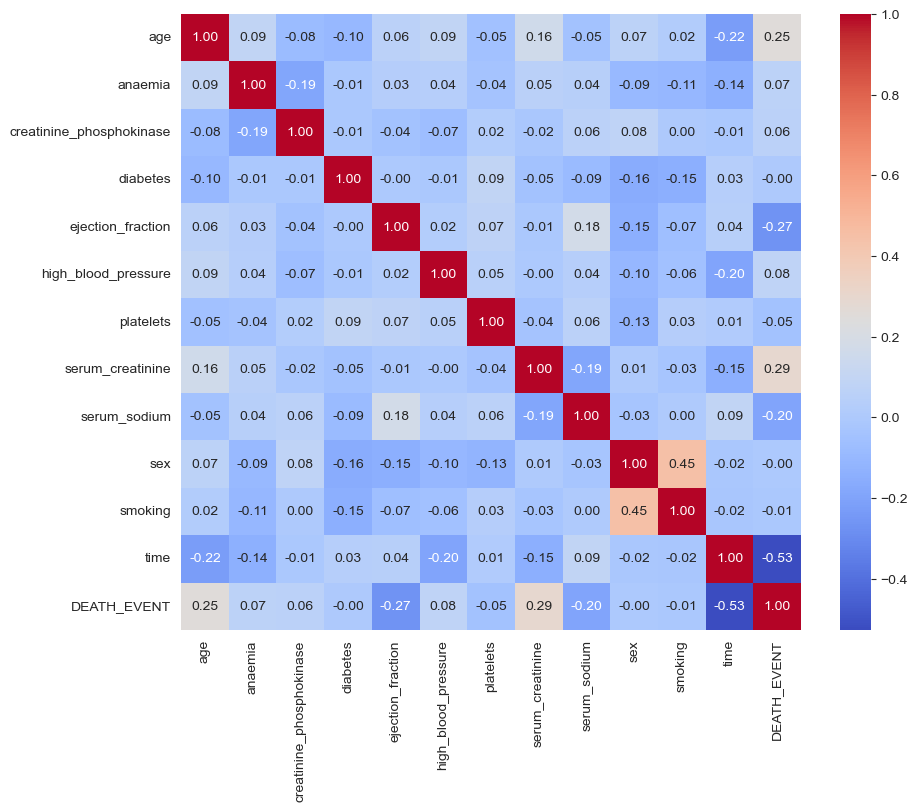

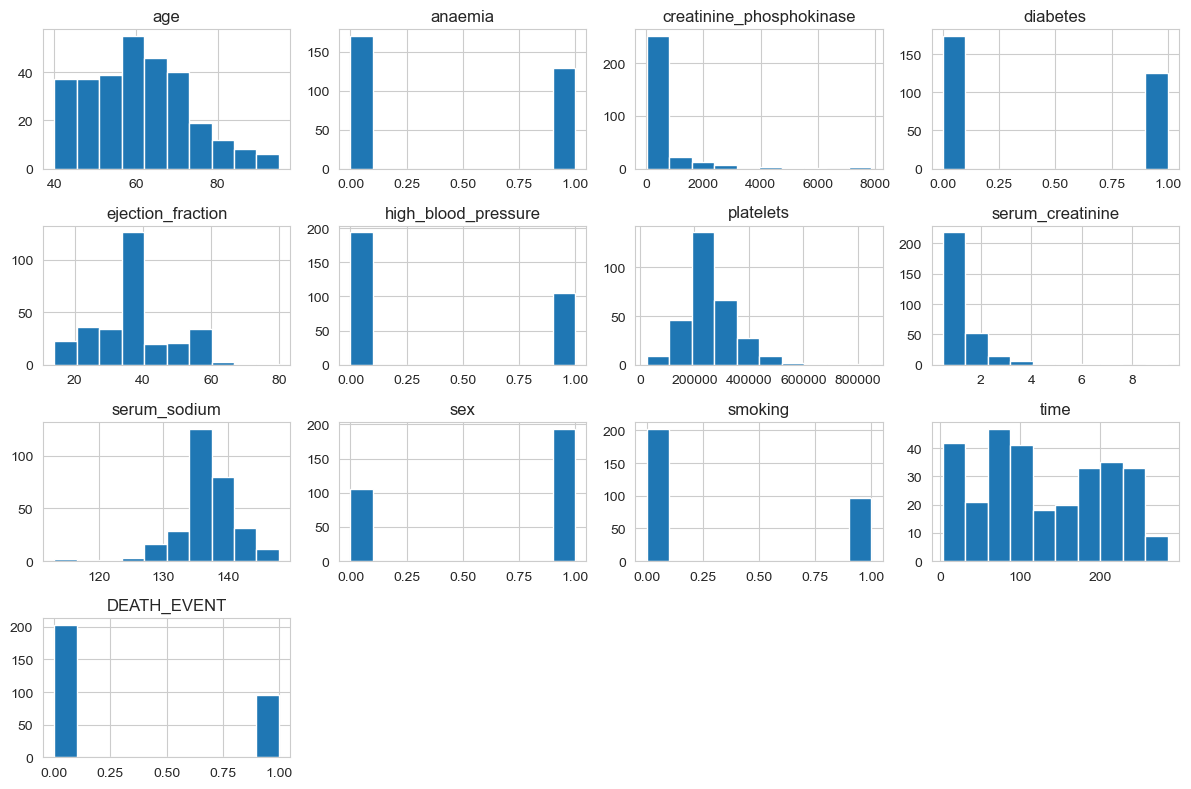

In [4]:
# Cell 4 - Correlation heatmap & simple histograms (optional)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

In [6]:
# Cell 5 - Split
X = df.drop(columns=[target])
y = df[target]

# hold out test 15%
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE)
# split trainval to train and val so final ~70/15/15
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.17647, stratify=y_trainval, random_state=RANDOM_STATE)
print("train/val/test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

train/val/test sizes: 209 45 45


In [7]:
# Cell 6 - Preprocessing
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
binary_cols = [c for c in numeric_cols if set(X[c].dropna().unique()).issubset({0,1})]
continuous_cols = [c for c in numeric_cols if c not in binary_cols]
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("continuous:", continuous_cols)
print("binary (0/1):", binary_cols)
print("categorical:", categorical_cols)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, continuous_cols),
    ("cat", categorical_pipeline, categorical_cols)
], remainder="passthrough")  # passes binary_cols through unchanged


continuous: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
binary (0/1): ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
categorical: []


In [10]:
# Cell 7 - Models + param grids
pipelines = {
    "logreg": Pipeline([("preprocessor", preprocessor), ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    "rf": Pipeline([("preprocessor", preprocessor), ("model", RandomForestClassifier(random_state=RANDOM_STATE))]),
    "xgb": Pipeline([("preprocessor", preprocessor), ("model", XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))]),
    "svc": Pipeline([("preprocessor", preprocessor), ("model", SVC(probability=True, random_state=RANDOM_STATE))])
}

param_grids = {
    "logreg": {"model__C": [0.01, 0.1, 1, 10]},
    "rf": {"model__n_estimators": [100, 200], "model__max_depth": [None, 5, 10]},
    "xgb": {"model__n_estimators": [100, 200], "model__max_depth": [3,5], "model__learning_rate": [0.01,0.1]},
    "svc": {"model__C": [0.1,1,10], "model__kernel": ["rbf", "linear"]}
}


In [11]:
# Cell 8 - Grid search (may take some minutes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

best_estimators = {}
val_metrics = {}

for name in pipelines:
    print(f"\n==== Tuning {name} ====")
    grid = GridSearchCV(pipelines[name], param_grids[name], scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    best_estimators[name] = best
    print("Best params:", grid.best_params_)
    # evaluate on validation
    y_val_proba = best.predict_proba(X_val)[:,1]
    y_val_pred = best.predict(X_val)
    val_metrics[name] = {
        "roc_auc": roc_auc_score(y_val, y_val_proba),
        "accuracy": accuracy_score(y_val, y_val_pred),
        "precision": precision_score(y_val, y_val_pred, zero_division=0),
        "recall": recall_score(y_val, y_val_pred, zero_division=0),
        "f1": f1_score(y_val, y_val_pred, zero_division=0)
    }
    print("Validation metrics:", val_metrics[name])



==== Tuning logreg ====
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'model__C': 0.01}
Validation metrics: {'roc_auc': np.float64(0.9266666666666667), 'accuracy': 0.7555555555555555, 'precision': 0.8333333333333334, 'recall': 0.3333333333333333, 'f1': 0.47619047619047616}

==== Tuning rf ====
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__max_depth': 5, 'model__n_estimators': 200}
Validation metrics: {'roc_auc': np.float64(0.9244444444444444), 'accuracy': 0.8444444444444444, 'precision': 0.8333333333333334, 'recall': 0.6666666666666666, 'f1': 0.7407407407407407}

==== Tuning xgb ====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Validation metrics: {'roc_auc': np.float64(0.8844444444444445), 'accuracy': 0.8, 'precision': 0.75, 'recall': 0.6, 'f1': 0.6666666666666666}

==== Tuning svc ====
Fitting 5 folds for each of

In [12]:
# Cell 9 - Select best and evaluate on test
best_name = max(val_metrics.items(), key=lambda kv: kv[1]['roc_auc'])[0]
print("Selected model:", best_name)
final_pipeline = best_estimators[best_name]

# evaluate test
y_test_proba = final_pipeline.predict_proba(X_test)[:,1]
y_test_pred = final_pipeline.predict(X_test)
test_results = {
    "roc_auc": roc_auc_score(y_test, y_test_proba),
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, zero_division=0),
    "recall": recall_score(y_test, y_test_pred, zero_division=0),
    "f1": f1_score(y_test, y_test_pred, zero_division=0),
    "confusion_matrix": confusion_matrix(y_test, y_test_pred).tolist()
}
print("Test results:", test_results)


Selected model: logreg
Test results: {'roc_auc': np.float64(0.8548387096774193), 'accuracy': 0.7333333333333333, 'precision': 1.0, 'recall': 0.14285714285714285, 'f1': 0.25, 'confusion_matrix': [[31, 0], [12, 2]]}


In [13]:
# Cell 10 - Save pipeline and metadata
os.makedirs("artifacts", exist_ok=True)
pipeline_path = "artifacts/heart_failure_pipeline.pkl"
joblib.dump(final_pipeline, pipeline_path)
print("Saved pipeline:", pipeline_path)

meta = {"features": X_train.columns.tolist(), "target": target, "model": best_name}
with open("artifacts/meta.json", "w") as f:
    json.dump(meta, f)
print("Saved metadata: artifacts/meta.json")


Saved pipeline: artifacts/heart_failure_pipeline.pkl
Saved metadata: artifacts/meta.json
